<a href="https://colab.research.google.com/github/ChawinOph/Jupyter-Notebooks/blob/master/Spring_SystemID.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
### Connect Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
### Import Libraries
import os
import sys

import numpy as np
import pandas as pd
import scipy
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt

import matplotlib.pyplot as plt
import seaborn as sns

# Set data path (To access: add shortcut of this shared folder to your 'My Drive')
main_path = '/content/drive/MyDrive/Victor_Trunk_Biomechanics'

**Given a mass–spring–damper system:**  
$$ m\ddot x + c\dot x + kx = 0 $$

---

### Step 1 — Measure Stiffness (k)
Static deflection test:  
$$ k = \frac{F}{x - x_0} $$

---

### Step 2 — Natural Frequency ($\omega_n$)
$$ \omega_n = \sqrt{\frac{k}{m}} $$

---

### Step 3 — Measure Damped Period ($T_d$)
From free vibration:  
$$ \omega_d = \frac{2\pi}{T_d} $$

---

### Step 4 — Damping Ratio

**Method A (Using $(T_d$)):**  
$$ \zeta = \sqrt{1 - \left(\frac{\omega_d}{\omega_n}\right)^2} $$

Expanded:  
$$ \zeta = \sqrt{1 - \left(\frac{2\pi}{T_d}\sqrt{\frac{m}{k}}\right)^2} $$

**[SELECTED] Method B (Logarithmic Decrement):**  
Measure peaks $(x_0, x_n$):  
$$ \delta = \frac{1}{n}\ln\left(\frac{x_0}{x_n}\right) $$

$$ \zeta = \frac{\delta}{\sqrt{4\pi^2 + \delta^2}} $$

Small damping approx [Not used]:  
$$ \zeta \approx \frac{\delta}{2\pi} $$

---

### Step 5 — Damping Coefficient ($c$)
$$ c = 2\zeta m \omega_n $$

Equivalent form:  
$$ c = 2\zeta\sqrt{km} $$



Test Name: A.SpringModelB_1lb


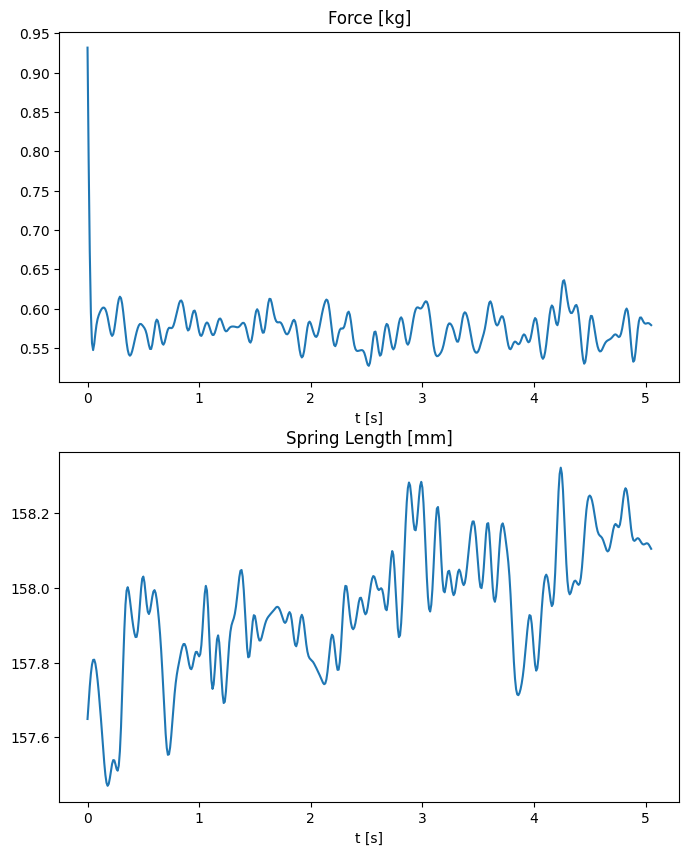

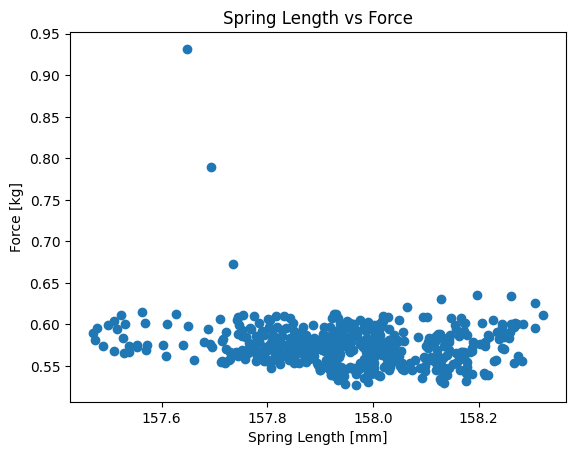


Test Name: C.SpringModelB_4lb


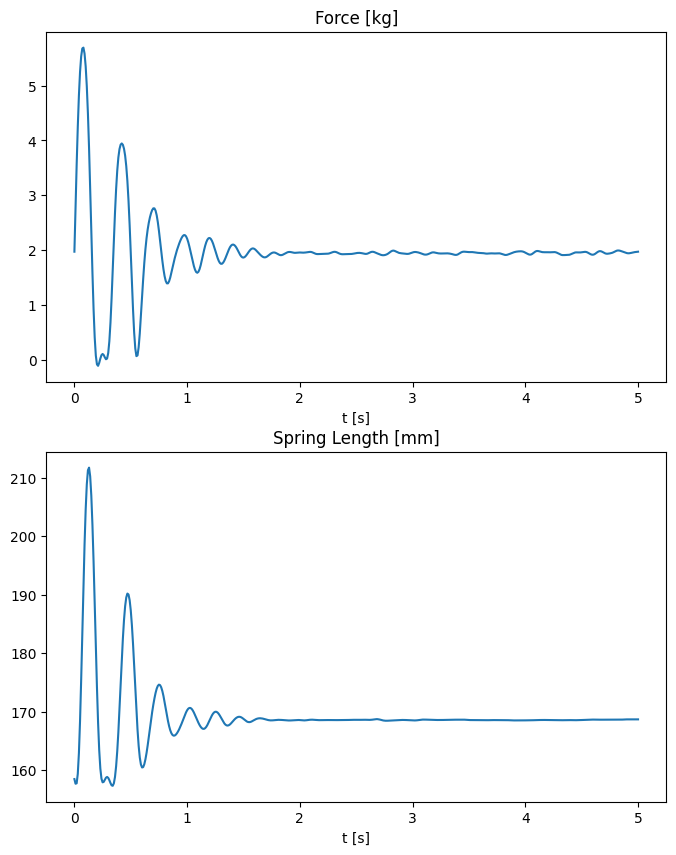

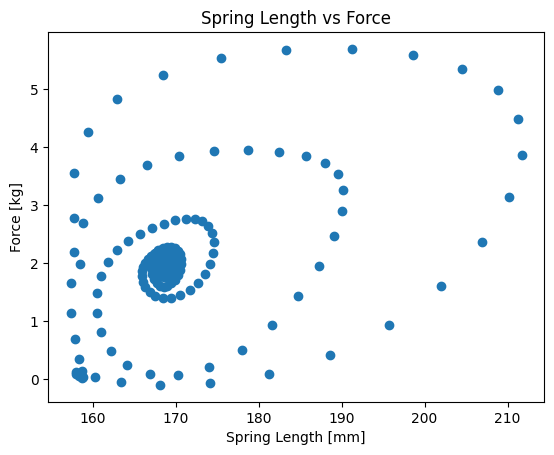


Test Name: D.SpringModelB_7Halflb


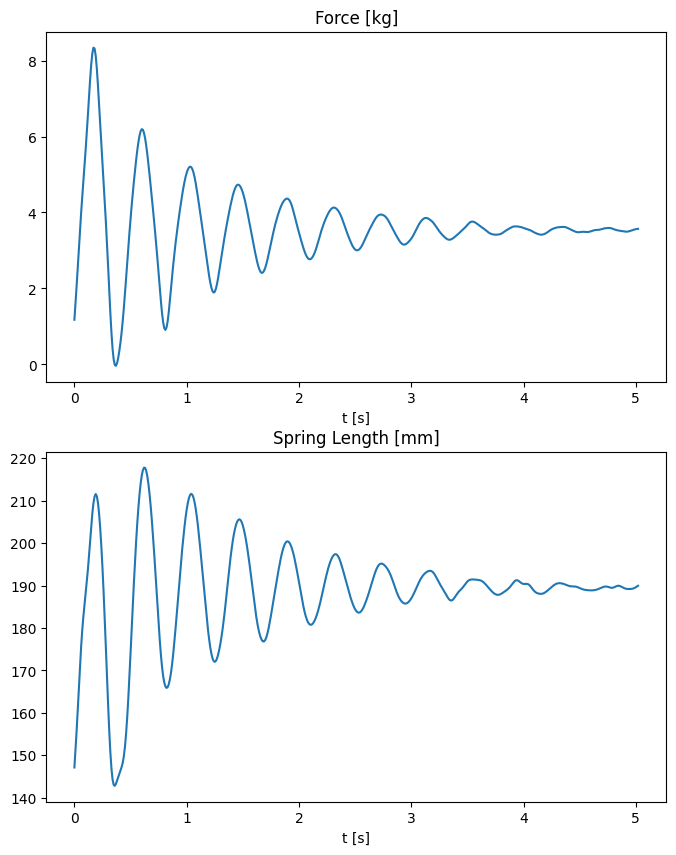

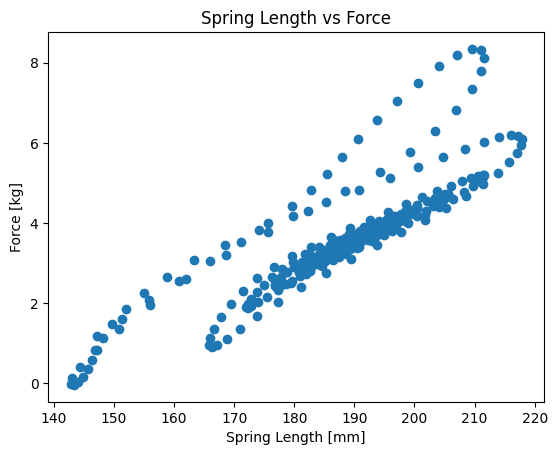


Computing Damping Ratio from Logarithmic Decrement: D.SpringModelB_7Halflb
Truncated peak arrays from 12 to 10


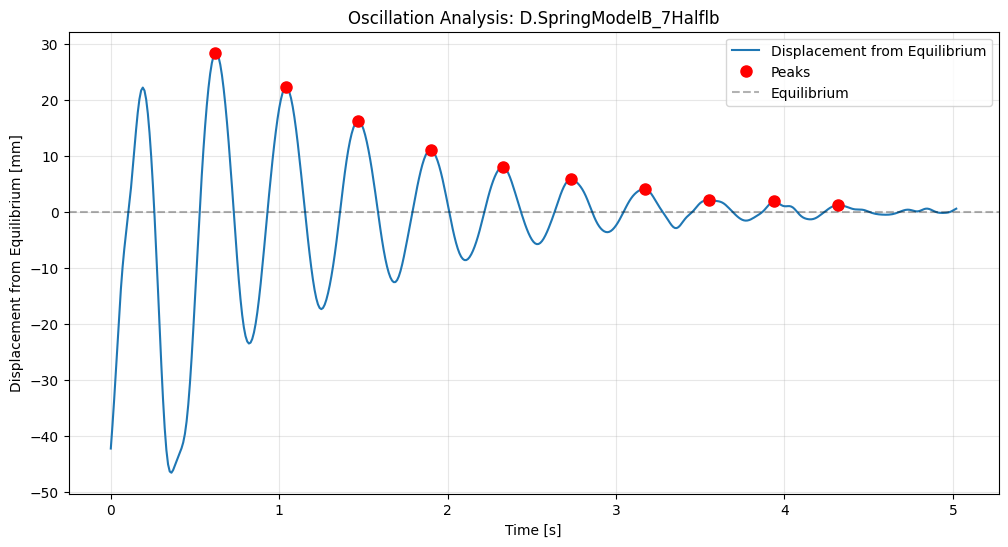

Equilibrium length: 189.40 mm
Number of peaks detected: 10
Individual log decrements: ['0.2452', '0.3145', '0.3850', '0.3211', '0.3252', '0.3456', '0.6865', '0.0937', '0.4637']
Average logarithmic decrement (δ): 0.3534
Damping ratio (ζ): 0.0562
Mass: 3.4019 kg

Test Name: E.SpringModelB_10lb


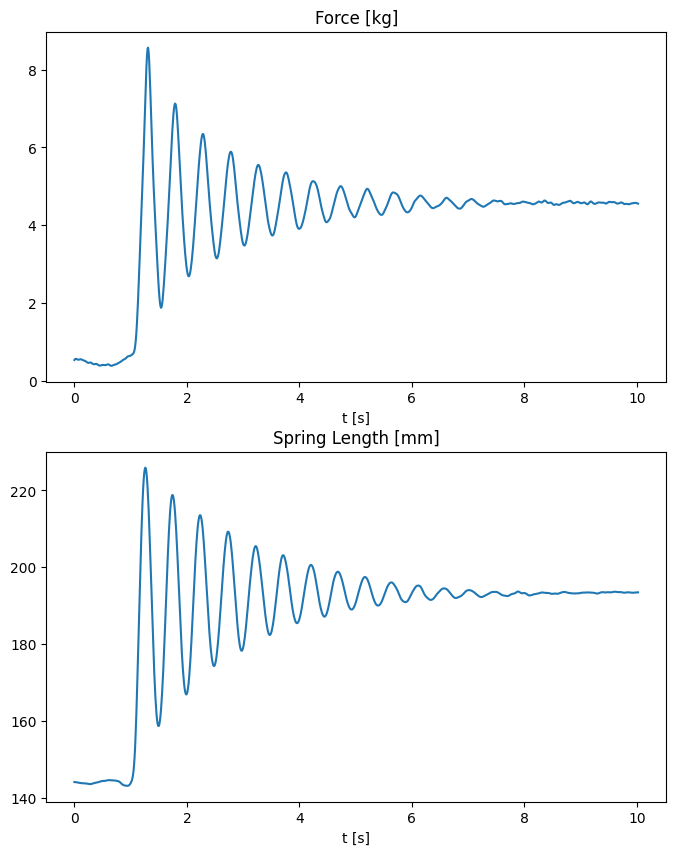

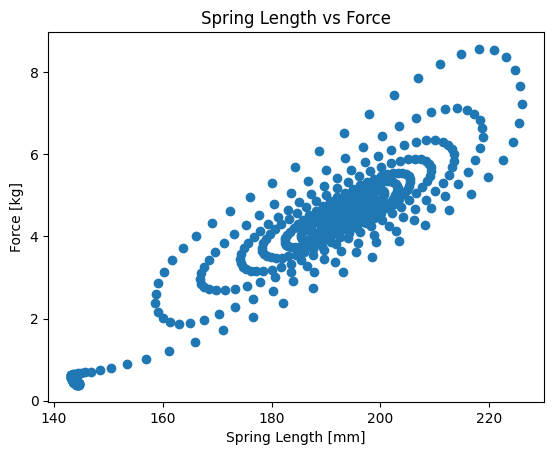


Computing Damping Ratio from Logarithmic Decrement: E.SpringModelB_10lb
Truncated peak arrays from 22 to 12


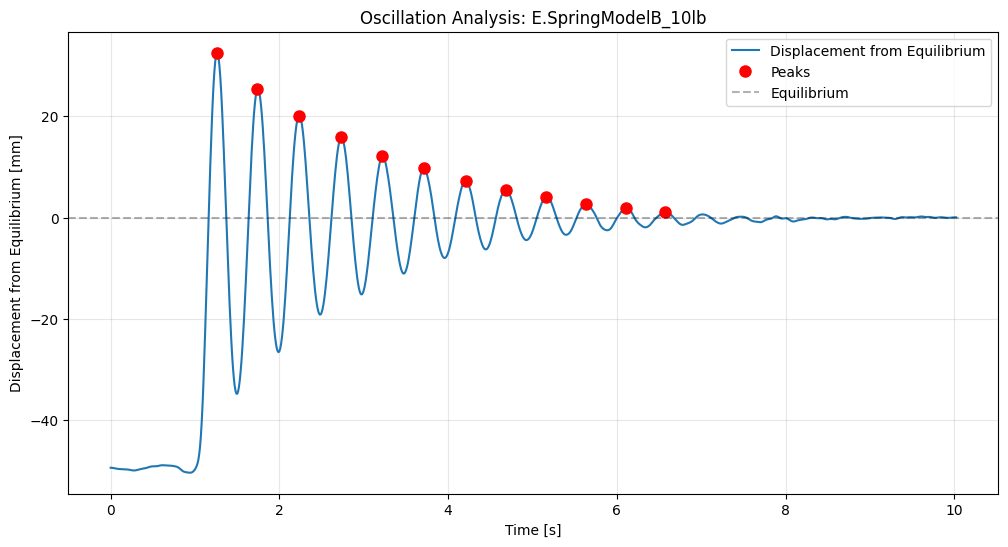

Equilibrium length: 193.44 mm
Number of peaks detected: 12
Individual log decrements: ['0.2477', '0.2324', '0.2397', '0.2707', '0.2178', '0.3039', '0.2831', '0.2945', '0.4277', '0.3762', '0.5253']
Average logarithmic decrement (δ): 0.3108
Damping ratio (ζ): 0.0494
Mass: 4.5359 kg

Approximate resting length (L0): 151.35 mm


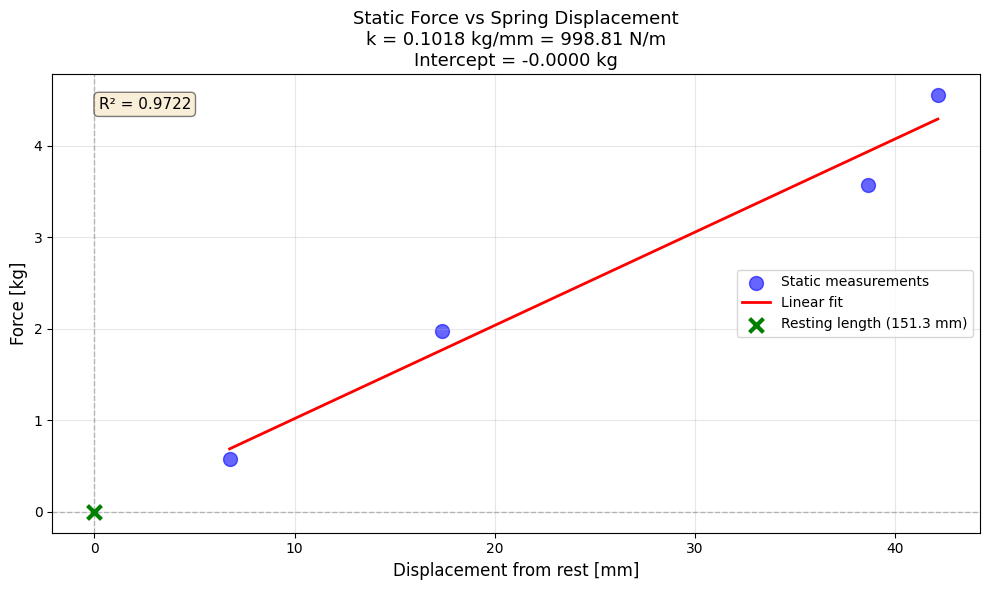


STIFFNESS RESULTS
Resting length (L0): 151.35 mm
Spring constant (k): 0.1018 kg/mm
Spring constant (k): 998.81 N/m
Intercept: -0.0000 kg (should be close to 0)
R² score: 0.9722

DAMPING COEFFICIENT CALCULATION

D.SpringModelB_7Halflb:
  Mass: 3.4019 kg
  Damping ratio (ζ): 0.0562
  Damping coefficient (c): 6.5467 N·s/m

E.SpringModelB_10lb:
  Mass: 4.5359 kg
  Damping ratio (ζ): 0.0494
  Damping coefficient (c): 6.6512 N·s/m

Average damping coefficient (c): 6.5989 ± 0.0522 N·s/m


In [14]:
# Extract Static Test Data
# Find k from known mg

stiffness_id_trial_names_dict = {
    'B_ShortSpring': ['A.SpringModelB_1lb',
                      'C.SpringModelB_4lb',
                      'D.SpringModelB_7Halflb',
                      'E.SpringModelB_10lb']
}

damping_id_trial_names_dict = {
    'B_ShortSpring': ['D.SpringModelB_7Halflb',
                      'E.SpringModelB_10lb']
}

mass_kg_dict = {
    'A.SpringModelB_1lb': 1*0.453592,
    'C.SpringModelB_4lb': 4*0.453592,
    'D.SpringModelB_7Halflb': 7.5*0.453592,
    'E.SpringModelB_10lb': 10*0.453592
}

valid_data_dict = {}

spring_name = 'B_ShortSpring'

static_force_ls = []
static_displacement_ls = []
static_length_ls = []
damping_data = {}

for test_name in stiffness_id_trial_names_dict[spring_name]:

  print(f"\n{'='*60}")
  print(f"Test Name: {test_name}")
  print(f"{'='*60}")

  data_path = os.path.join(main_path, "Data", "DATA EXPORTED")
  dynamometer_path = os.path.join(data_path, test_name + "_DYNAMOMETER_resampled_100Hz.csv")
  vicon_path = os.path.join(data_path, test_name + "_VICON.csv")

  df_dyna = pd.read_csv(dynamometer_path)
  df_vicon = pd.read_csv(vicon_path)

  # display(df_dyna)
  # display(df_vicon)

  t_dyna = df_dyna['t'].to_numpy()
  t_vicon = df_vicon['t'].to_numpy()
  t_trim = min(t_dyna[-1], t_vicon[-1])

  xyz_names = ['X_mm', 'Y_mm', 'Z_mm']
  distal_spring_col_names = [f'SpringModelSkeleton:DISTSPRINGBOTTOM_{axis_name}' for axis_name in xyz_names]
  proximal_spring_col_names = [f'SpringModelSkeleton:PROXSPRINGANT_{axis_name}' for axis_name in xyz_names]

  xyz_distal = df_vicon.loc[df_vicon['t'] <= t_trim, distal_spring_col_names].to_numpy()
  xyz_proximal = df_vicon.loc[df_vicon['t'] <= t_trim, proximal_spring_col_names].to_numpy()
  spring_vector = xyz_distal - xyz_proximal
  spring_lengths = np.linalg.norm(spring_vector, axis=1)
  dyna_force = df_dyna['CHANNEL_1'].to_numpy()

  # plot time series of spring length and force
  fig, axs = plt.subplots(2, 1, figsize=(8, 10))

  axs[0].plot(t_dyna, dyna_force)
  axs[0].set_title("Force [kg]")
  axs[0].set_xlabel('t [s]')

  axs[1].plot(t_dyna, spring_lengths)
  axs[1].set_title("Spring Length [mm]")
  axs[1].set_xlabel('t [s]')

  plt.show()

  # plot
  fig, ax = plt.subplots()
  ax.scatter(spring_lengths, dyna_force)
  ax.set_xlabel("Spring Length [mm]")
  ax.set_ylabel("Force [kg]")
  ax.set_title("Spring Length vs Force")
  plt.show()

  # obtain static force-displacement pair (final value)
  static_force_ls.append(dyna_force[-1])
  static_length_ls.append(spring_lengths[-1])

  if test_name in damping_id_trial_names_dict[spring_name]:
    print(f"\n{'='*60}")
    print(f"Computing Damping Ratio from Logarithmic Decrement: {test_name}")
    print(f"{'='*60}")

    # Find equilibrium position (mean of last 10% of data)
    equilibrium_length = np.mean(spring_lengths[int(0.9*len(spring_lengths)):])

    # Calculate displacement from equilibrium
    displacement_from_eq = spring_lengths - equilibrium_length

    # Find peaks in the displacement signal for logarithmic decrement
    from scipy.signal import find_peaks

    # Find positive peaks (above equilibrium)
    peaks, _ = find_peaks(displacement_from_eq, distance=10, height=0)

    # manually skip the first peak of 7.5 lb test
    if test_name == 'D.SpringModelB_7Halflb':
      peaks = peaks[1:]

    if len(peaks) > 1:

      # Calculate logarithmic decrements between consecutive peaks
      peak_amplitudes = displacement_from_eq[peaks]
      log_decrements = []

      settling_threshold = 0.02  # 2% settling time criterion (standard)

      for i in range(len(peak_amplitudes) - 1):
          if peak_amplitudes[i] > 0 and peak_amplitudes[i+1] > 0:
              ratio_to_init = peak_amplitudes[i+1] / peak_amplitudes[0]
              if ratio_to_init > settling_threshold:
                  ratio = peak_amplitudes[i] / peak_amplitudes[i+1]
                  delta = np.log(ratio)
                  log_decrements.append(delta)
              else:
                  init_peak_length = len(peaks)
                  peaks = peaks[:i+1]  # Truncate peaks array
                  print(f"Truncated peak arrays from {init_peak_length} to {len(peaks)}")
                  break

      # Extract data for validation
      t_val = t_dyna[peaks[0]:] - t_dyna[peaks[0]]
      valid_data_dict[test_name] = {'t': t_val,
                                    'x': displacement_from_eq[peaks[0]:]}

      # Plot oscillations with peaks marked
      fig, ax = plt.subplots(figsize=(12, 6))
      ax.plot(t_dyna, displacement_from_eq, label='Displacement from Equilibrium')
      ax.plot(t_dyna[peaks], displacement_from_eq[peaks], 'ro', markersize=8, label='Peaks')
      ax.axhline(y=0, color='k', linestyle='--', alpha=0.3, label='Equilibrium')
      ax.set_xlabel('Time [s]')
      ax.set_ylabel('Displacement from Equilibrium [mm]')
      ax.set_title(f'Oscillation Analysis: {test_name}')
      ax.legend()
      ax.grid(True, alpha=0.3)
      plt.show()

      if len(log_decrements) > 0:
        # Average logarithmic decrement
        delta_avg = np.mean(log_decrements)

        # Calculate damping ratio from logarithmic decrement
        # ζ = δ / sqrt((2π)² + δ²)
        zeta = delta_avg / np.sqrt((2 * np.pi)**2 + delta_avg**2)

        # Extract mass from dictionary
        mass_kg = mass_kg_dict[test_name]

        # Store damping data
        damping_data[test_name] = {
            'mass_kg': mass_kg,
            'delta': delta_avg,
            'zeta': zeta,
            'num_peaks': len(peaks),
            'log_decrements': log_decrements,
            'equilibrium_length': equilibrium_length
        }

        print(f"Equilibrium length: {equilibrium_length:.2f} mm")
        print(f"Number of peaks detected: {len(peaks)}")
        print(f"Individual log decrements: {[f'{d:.4f}' for d in log_decrements]}")
        print(f"Average logarithmic decrement (δ): {delta_avg:.4f}")
        print(f"Damping ratio (ζ): {zeta:.4f}")
        print(f"Mass: {mass_kg:.4f} kg")
      else:
        print(f"Warning: Could not calculate valid log decrements for {test_name}")
    else:
      print(f"Warning: Not enough peaks detected for {test_name}")

# Approximate resting length (x-intercept of force-length relationship)
# Using linear regression to find where force = 0
from sklearn import datasets, linear_model, metrics

x_length = np.array(static_length_ls).reshape((-1, 1))
y_force = np.array(static_force_ls)

reg_length = linear_model.LinearRegression()
reg_length.fit(x_length, y_force)

# Resting length is where force = 0: 0 = slope * L0 + intercept
# L0 = -intercept / slope
L0 = -reg_length.intercept_ / reg_length.coef_[0]

print(f"\nApproximate resting length (L0): {L0:.2f} mm")

# Calculate displacements from resting length
static_displacement_ls = np.array(static_length_ls) - L0

# Compute regression using displacement (x = displacement from rest)
x_disp = static_displacement_ls.reshape((-1, 1))
y_force_kg = np.array(static_force_ls)

reg = linear_model.LinearRegression()
reg.fit(x_disp, y_force_kg)

# Spring constant in kg/mm
k_kg_per_mm = reg.coef_[0]

# Convert to N/m
# Force: kg → N (multiply by g = 9.81 m/s²)
# Displacement: mm → m (divide by 1000)
# k [N/m] = k [kg/mm] * 9.81 [N/kg] / 0.001 [m/mm]
k_N_per_m = k_kg_per_mm * 9.81 / 0.001

# Plot regression
fig, ax = plt.subplots(figsize=(10, 6))

# Scatter plot of data points
ax.scatter(x_disp, y_force_kg, color='blue', s=100, alpha=0.6, label='Static measurements')

# Regression line
x_line = np.linspace(x_disp.min(), x_disp.max(), 100).reshape(-1, 1)
y_pred = reg.predict(x_line)
ax.plot(x_line, y_pred, color='red', linewidth=2, label='Linear fit')

# Add origin point (resting length)
ax.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax.axvline(x=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax.scatter([0], [0], color='green', s=100, marker='x', linewidths=3,
           label=f'Resting length ({L0:.1f} mm)', zorder=5)

# Labels and formatting
ax.set_xlabel("Displacement from rest [mm]", fontsize=12)
ax.set_ylabel("Force [kg]", fontsize=12)
ax.set_title(f"Static Force vs Spring Displacement\n" +
             f"k = {k_kg_per_mm:.4f} kg/mm = {k_N_per_m:.2f} N/m\n" +
             f"Intercept = {reg.intercept_:.4f} kg", fontsize=13)
ax.legend()
ax.grid(True, alpha=0.3)

# Display R² score
r2 = reg.score(x_disp, y_force_kg)
ax.text(0.05, 0.95, f'R² = {r2:.4f}', transform=ax.transAxes,
        fontsize=11, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print(f"\n{'='*60}")
print(f"STIFFNESS RESULTS")
print(f"{'='*60}")
print(f"Resting length (L0): {L0:.2f} mm")
print(f"Spring constant (k): {k_kg_per_mm:.4f} kg/mm")
print(f"Spring constant (k): {k_N_per_m:.2f} N/m")
print(f"Intercept: {reg.intercept_:.4f} kg (should be close to 0)")
print(f"R² score: {r2:.4f}")

# Compute damping coefficient from damping ratios
if damping_data:
    print(f"\n{'='*60}")
    print(f"DAMPING COEFFICIENT CALCULATION")
    print(f"{'='*60}")

    c_values = []

    for test_name, data in damping_data.items():
        # Get mass in kg from dictionary (already in kg)
        m = data['mass_kg']
        zeta = data['zeta']

        # c = 2 * ζ * sqrt(k * m)
        # where k is in N/m and m is in kg
        c = 2 * zeta * np.sqrt(k_N_per_m * m)
        c_values.append(c)

        print(f"\n{test_name}:")
        print(f"  Mass: {m:.4f} kg")
        print(f"  Damping ratio (ζ): {zeta:.4f}")
        print(f"  Damping coefficient (c): {c:.4f} N·s/m")

    # Average damping coefficient
    c_avg = np.mean(c_values)
    c_std = np.std(c_values)

    print(f"\n{'='*60}")
    print(f"Average damping coefficient (c): {c_avg:.4f} ± {c_std:.4f} N·s/m")
    print(f"{'='*60}")

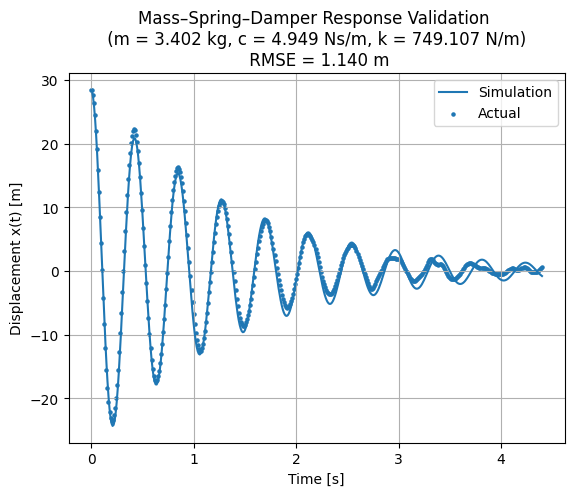

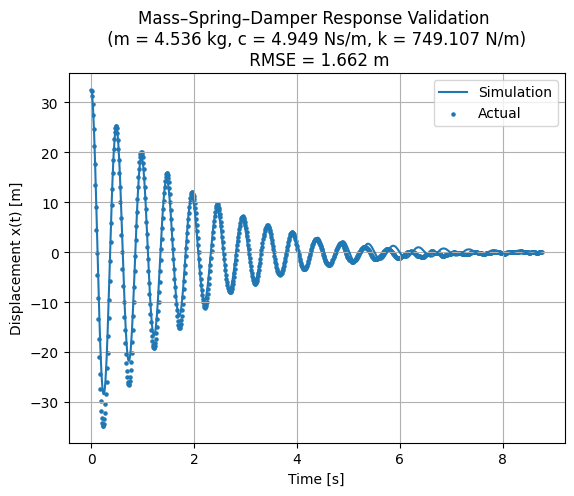

In [45]:
from scipy.integrate import solve_ivp
# Validate simulation vs dataset (rmse actual vs model)
# Simulate Free Damped Vibration with initial displacement as the first peak in the response
k = k_N_per_m*.75
c = c_avg*0.75

def msd_dynamics(t, state):
  x, xdot = state
  xddot = -(c/m)*xdot - (k/m)*x
  return [xdot, xddot]

for test_name in damping_id_trial_names_dict[spring_name]:
  test_valid_data = valid_data_dict[test_name]
  m = mass_kg_dict[test_name]
  t_val = test_valid_data['t']
  x_val = test_valid_data['x']
  x0 = x_val[0]
  xdot0 = 0.0   # initial velocity
  state0 = [x0, xdot0]

  # dt = t[1] - t[0]
  # t_span = [t[0], t[-1]]
  # t_eval = np.arange(t[0], t[-1], dt)

  sol = solve_ivp(msd_dynamics, [t_val[0], t_val[-1]], state0, t_eval=t_val)

  t_sol = sol.t
  x_sol = sol.y[0]
  xdot_sol = sol.y[1]

  rmse = np.sqrt(np.mean((x_val - x_sol)**2))
  # rmse_pc = rmse / x_val.mean() * 100

  plt.figure()
  plt.plot(t_sol, x_sol, label='Simulation')
  plt.scatter(t_val, x_val, label='Actual', s = 5)
  plt.xlabel("Time [s]")
  plt.ylabel("Displacement x(t) [m]")
  plt.title(f"Mass–Spring–Damper Response Validation \n (m = {m:.3f} kg, c = {c:.3f} Ns/m, k = {k:.3f} N/m) \n RMSE = {rmse:.3f} m")
  plt.grid(True)
  plt.legend()
  plt.show()